NHLBI Workshop Tutorial
##Big Data Integration: Unlocking the Potential for Enhanced Epidemiological Research
09/27/2023 16:00
Tutorial 1 - Day 1
##**Heterogeneous Transfer Learning Dealing with Unmatched Features**
###Author: **Ruzhang Zhao** and Dr. Nilanjan Chatterjee, Johns Hopkins University
Facilitator: Dr. Gabriel Anaya - NHLBI - NIH

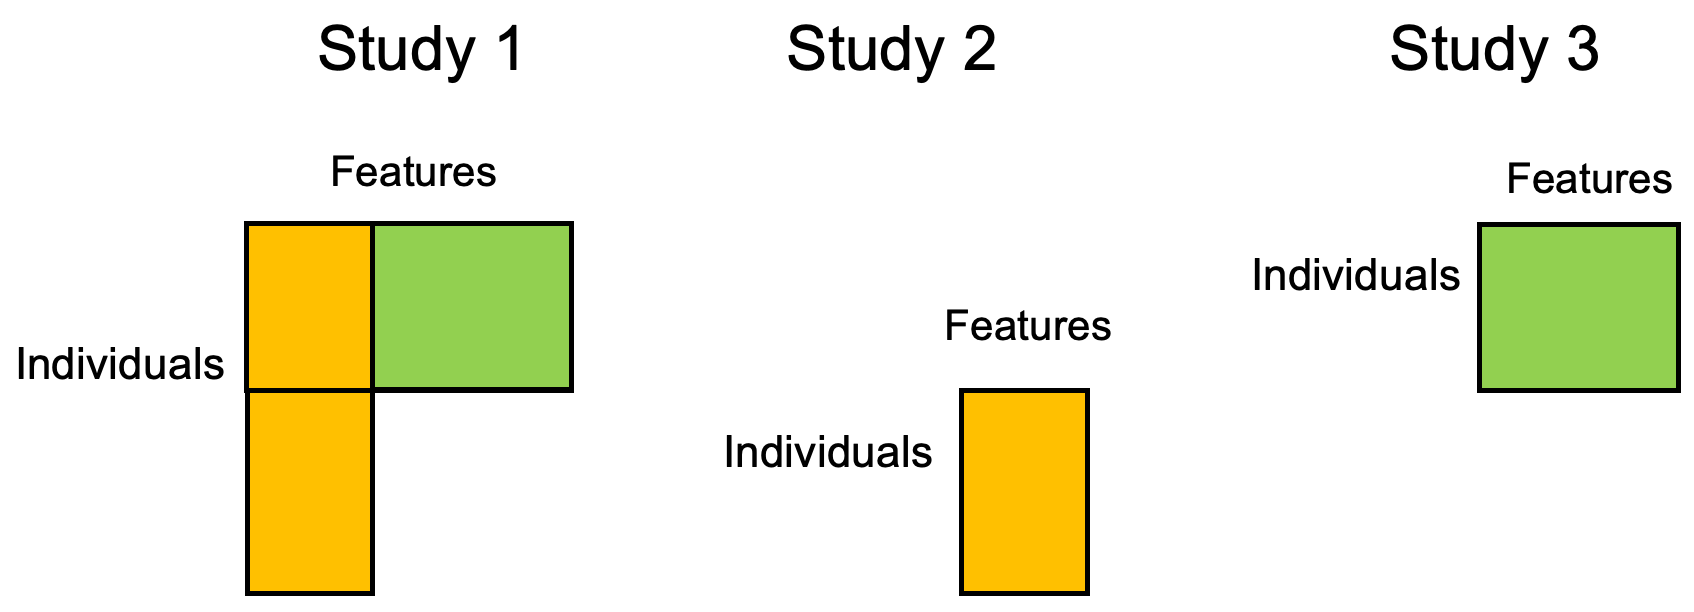

This tutorial serves as an introduction of HTL-GMM method (Heterogeneous Transfer Learning with Generalized Method of Moments). We will introduce the R package usage and a "simulated" real-world data application examples.

# Installation and Setup

In [1]:
# Set up environment to be able to use R in Google Collab
%load_ext rpy2.ipython

In [43]:
%%R
# Install required libraries/dependencies
installed.packages("devtools")
library(devtools)
devtools::install_github("RuzhangZhao/htlgmm")

  Use `force = TRUE` to force installation



# Method Recap

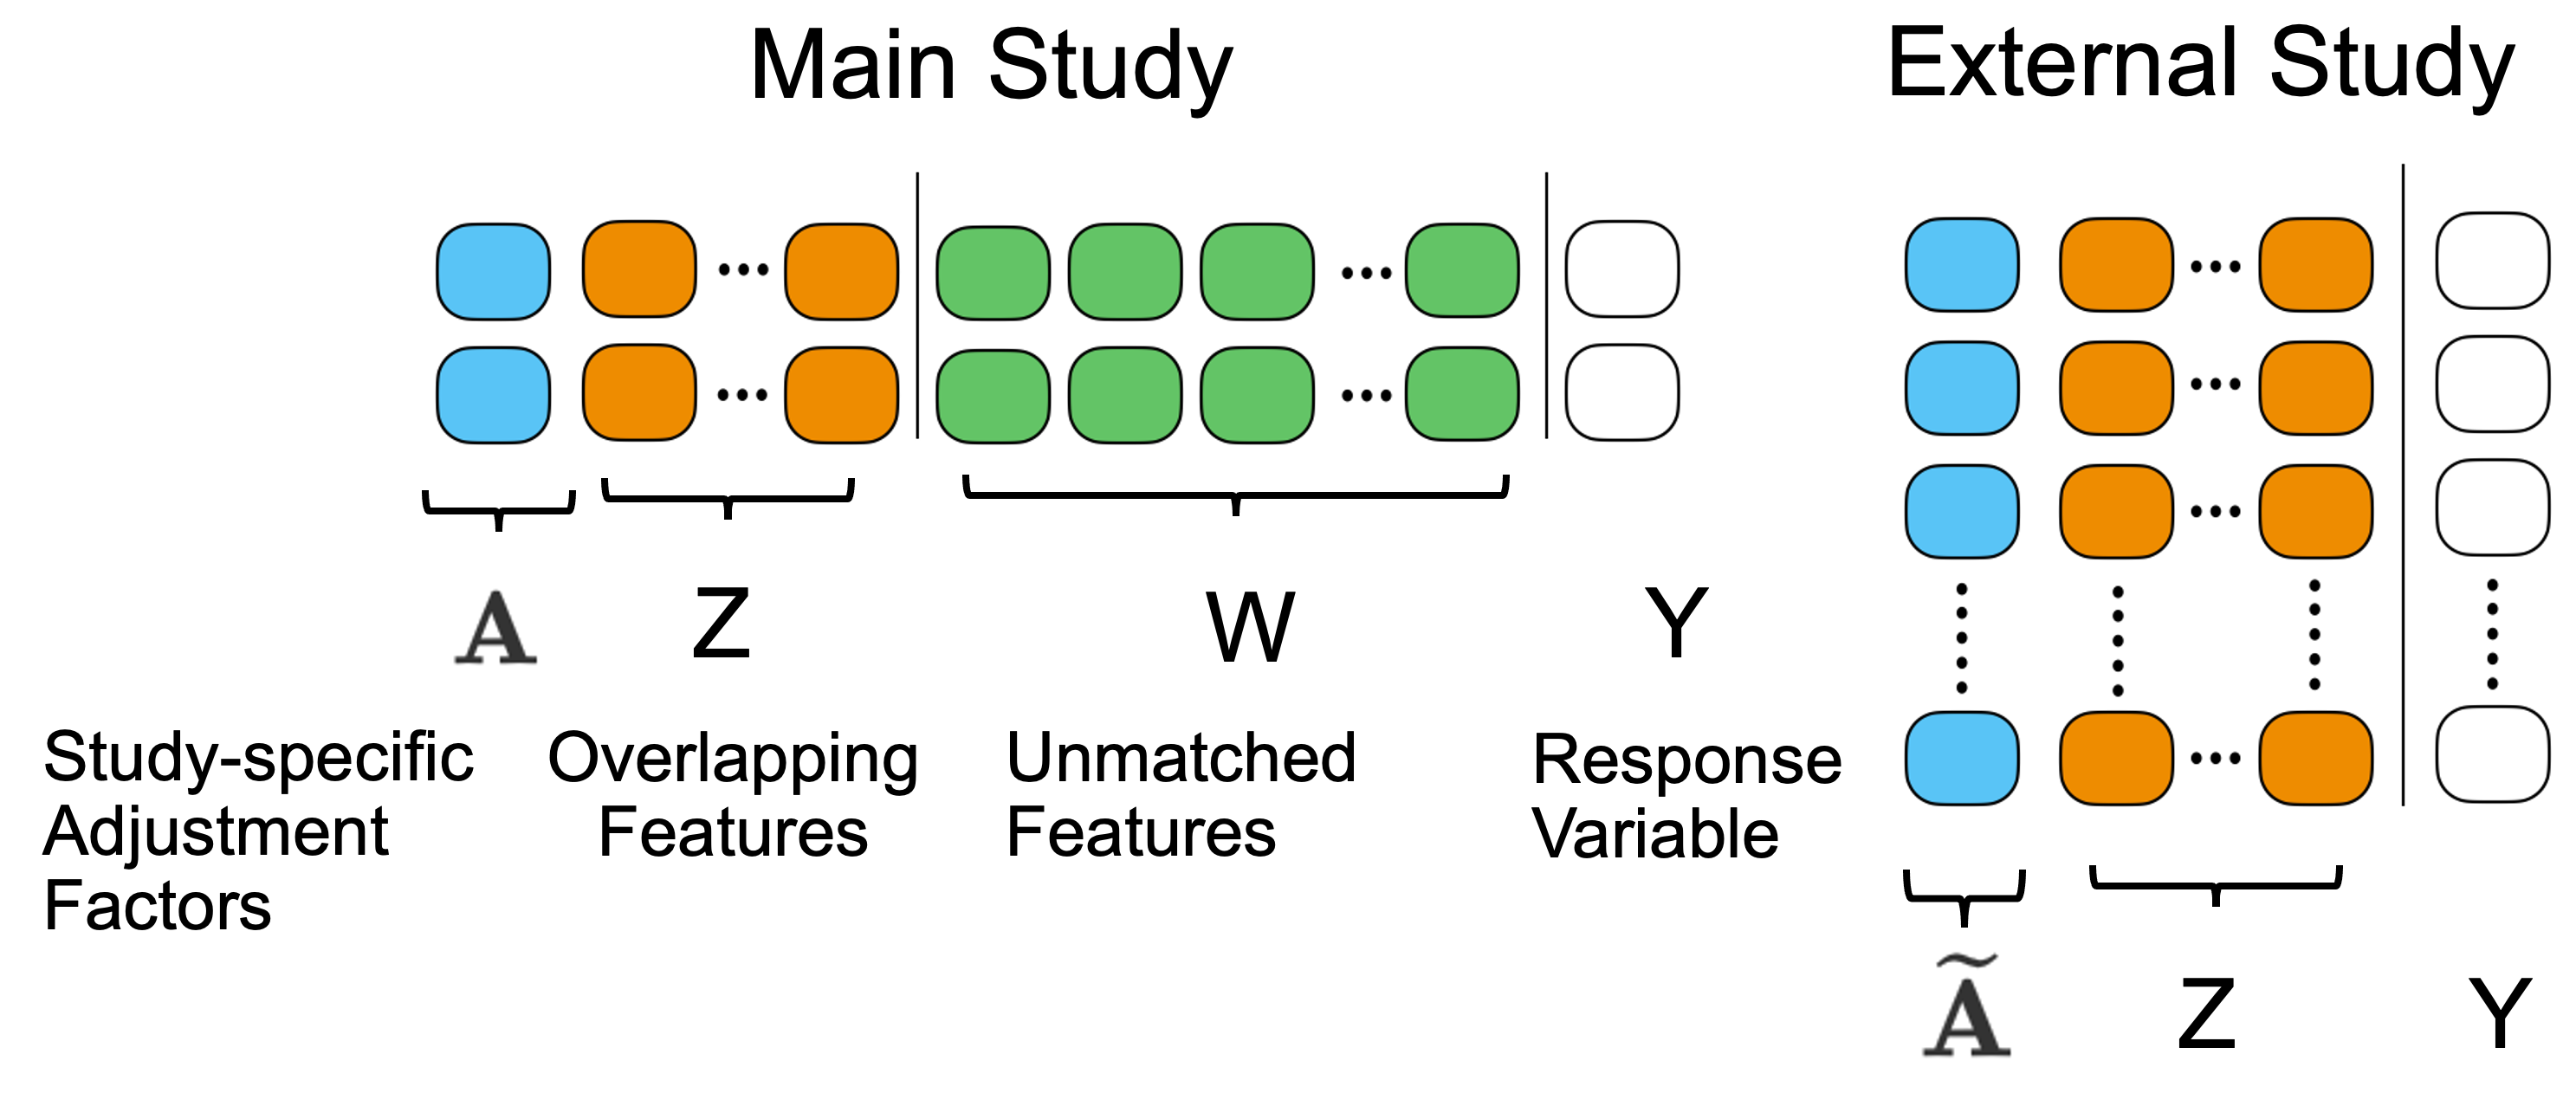

* Main study and external study can from the same or different population.

* External study can be in the form of individual data or trained model with parameter estimation.

# Usage of Package **`htlgmm`**

### Quick review of R package `glmnet`

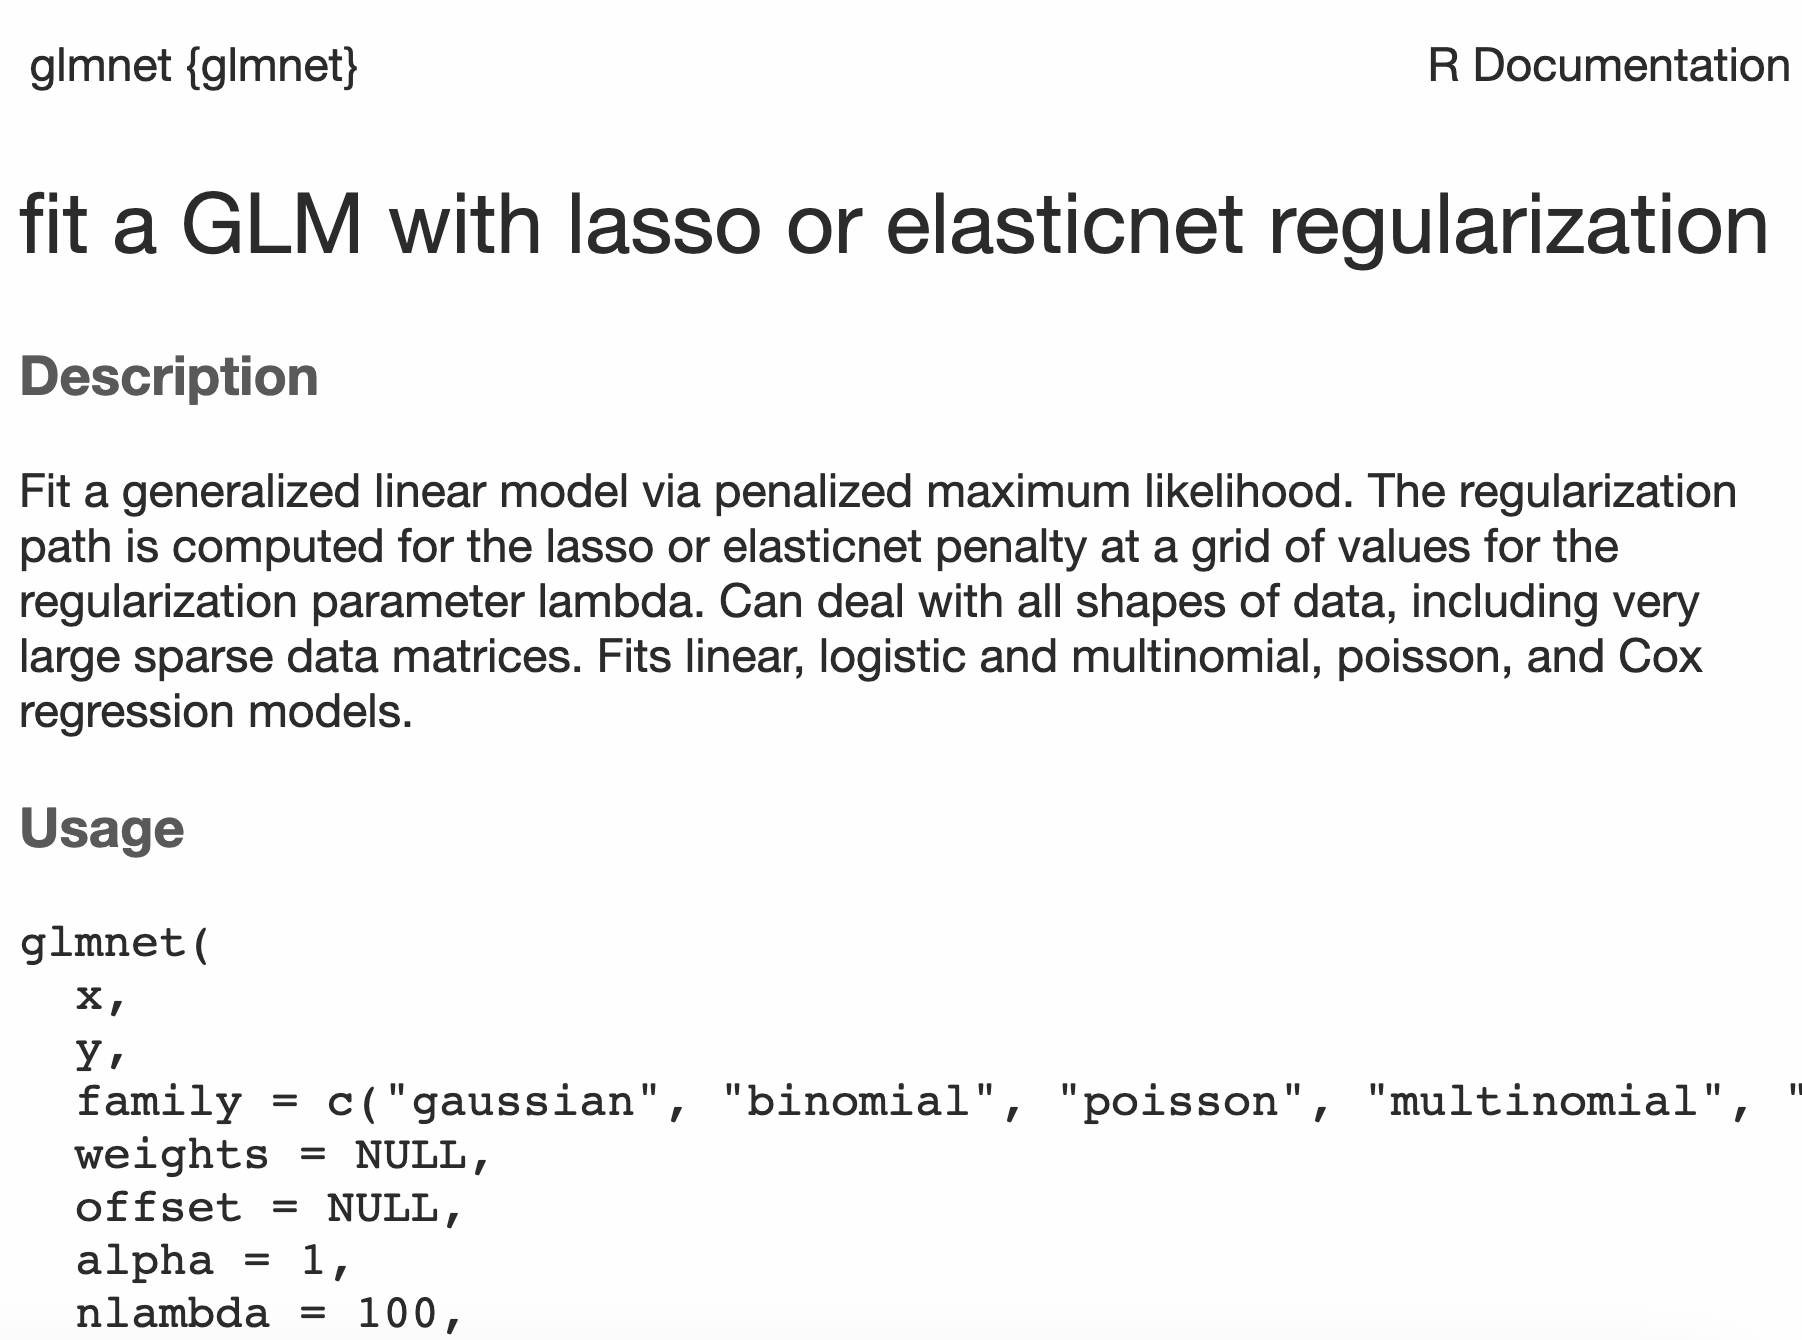


## Primary Functions of package **`htlgmm`**

Functions **`htlgmm`** and **`cv.htlgmm`** work similarly like functions **`glmnet`** and **`cv.glmnet`** from R package **`glmnet`**. **`cv.glmnet`**/**`cv.htlgmm`** does cross validation with an automatically generated tuning parameter list to select tuning parameters. We recommend users to use `cv.htlgmm` without knowing prefixed tuning parameters.



## Simple Examples

The simulation example is to illustrate how the `cv.htlgmm` method is implemented, compared with `cv.glmnet`. The simulation is performed under both linear and logistic regression settings. We use **20** overlapping features (**Z**) and **3** unmatched features (**W**). 3/20 of **Z** whose effects on outcome are nonzero, while 2/3 of **W** whose effects on outcome are nonzero.

### Simulation Setup

In [4]:
%%R
# Simulation Step
library(htlgmm)
pZ=20 # overlapping feature size
pW=3 # unmatched feature size
coef<-c(rep(0,pZ+pW))
coef[1:3]<-0.5
coef[c(21,22)]<-0.5
which(coef!=0)

[1]  1  2  3 21 22


Main study sample size **n** is 400, while external study sample size **nE** is 2000.

In [5]:
%%R
# Create Study Sample
n=400
nE=2000
n_joint=n+nE
main_index<-1:n

We jointly generate main and external studies.

In [6]:
%%R

# Generate Main and external study data
set.seed(2023)
Z_joint<-matrix(rnorm(n_joint*pZ),n_joint,pZ)
colnames(Z_joint)<-paste0("Z",1:pZ)
W_joint<-matrix(rnorm(n_joint*pW),n_joint,pW)
colnames(W_joint)<-paste0("W",1:pW)
Z<-Z_joint[main_index,]  # separate main and external study for Z
ZE<-Z_joint[-main_index,]

W<-W_joint[main_index,] # only need main study for W

**y** is generated with both **Z** and **W**.


In [7]:
%%R

# Generate Y for main and external data. Y is generated with both Z and W.
y_joint<-cbind(Z_joint,W_joint)%*%coef+rnorm(n_joint,0,1)
y<-y_joint[main_index] # separate main study y
yE<-y_joint[-main_index] # separate external study y

Display the data structure of main study **(y, Z, W)**.


In [8]:
%%R
# QA/QC - Display the Data Structure
main_study<-cbind(y,Z,W)
head(main_study,2)

              y          Z1         Z2         Z3         Z4        Z5
[1,]  0.1583804 -0.08378436 -0.1616781 -1.3225585 -0.8951142  1.383318
[2,] -1.5600714 -0.98294375 -0.6106287 -0.2736024 -1.5626956 -1.532501
            Z6          Z7        Z8         Z9        Z10        Z11
[1,] -1.238603 -0.41577864 2.2262279 -0.4355437 -1.2781105 0.09987105
[2,]  2.672741 -0.03547315 0.5557817 -2.6988094 -0.9780216 1.12832300
            Z12        Z13        Z14       Z15         Z16       Z17
[1,] -0.1749688  0.1048335  0.2623919  2.477921  0.34783666  0.504284
[2,] -1.7289105 -1.9954020 -0.4474806 -1.173848 -0.03577785 -1.899115
            Z18      Z19        Z20         W1        W2       W3
[1,] -0.6407976 1.750567 -1.3606713 -0.1165617 0.7678237 1.383503
[2,]  0.9483486 0.452172 -0.4931382 -0.9528922 0.7417592 1.648957


Display the data structure of external study **(yE,ZE)**.


In [9]:
%%R
# QA/QC - Display the Data Structure
external_study<-cbind(yE,ZE)
head(external_study,2)

             yE         Z1         Z2         Z3        Z4       Z5         Z6
[1,] -0.7521167 -0.5272182 -0.6934707 -0.4671187  1.690280 1.696264 0.00194452
[2,] -0.5669488  0.4289935 -0.9329976 -1.2707116 -1.873718 0.192479 0.05867523
            Z7         Z8        Z9        Z10        Z11      Z12        Z13
[1,] -0.565544  0.3158803 0.8435341  0.4943649 -0.9205529 1.557621 -0.4550360
[2,]  1.316755 -2.9078613 0.2431169 -1.2291510  0.1720111 1.082391 -0.2680297
            Z14        Z15        Z16       Z17        Z18        Z19       Z20
[1,] -0.1501486 -0.8853446 -1.4658571 0.2602220 -0.8654340 -0.3140345 -0.202401
[2,] -1.3407530  2.3817827  0.4602121 0.3496314  0.5179547  0.2368451  1.286966


Scale the **Z** and **W** predictors


In [10]:
%%R
# Scale Z and W Predictors
Z<-scale(Z)
ZE<-scale(ZE)
W<-scale(W)


## How `cv.glmnet` works

We do `cv.glmnet` for lasso only on main study.

In [11]:
%%R
# Apply cv.glmnet
library(glmnet)
res_glmnet<-cv.glmnet(x=cbind(Z,W),y=y)
est_coef_glmnet<-coef.glmnet(res_glmnet,s="lambda.min")[-1] # without intercept


## Train with External Study

Summarize external study to be trained model with parameter estimation. Here we use OLS with external study **(yE,ZE)**. Extract estimated coefficients (other than intercept terms, only for **Z**), variance-covariance matrix, and external study sample size. Convert the results into list.


In [12]:
%%R
# Train with External Study Data
reslm<-lm(y~.,data = data.frame(y=yE,ZE))
study_external = list(
  Coeff=reslm$coefficients[-1],
  Covariance=vcov(reslm)[-1,-1],
  Sample_size=nE)
study_info<-list()
study_info[[1]] <- study_external # The study_info is also a list because we can support multiple external studies.
print(study_info)

[[1]]
[[1]]$Coeff
          Z1           Z2           Z3           Z4           Z5           Z6 
 0.530887961  0.523099158  0.532351085 -0.015364172 -0.027326437 -0.002802013 
          Z7           Z8           Z9          Z10          Z11          Z12 
-0.027650441  0.023533321  0.029561786 -0.052100994 -0.034262997  0.009395467 
         Z13          Z14          Z15          Z16          Z17          Z18 
 0.045207086  0.002831175  0.021770349  0.016790848 -0.004875441  0.018700448 
         Z19          Z20 
-0.011323427  0.006020014 

[[1]]$Covariance
               Z1            Z2            Z3            Z4            Z5
Z1   7.763687e-04  5.349850e-06 -3.095732e-05  2.149873e-05  1.170982e-06
Z2   5.349850e-06  7.780699e-04 -1.008111e-05  3.769039e-05 -3.791443e-05
Z3  -3.095732e-05 -1.008111e-05  7.738355e-04 -1.386411e-05 -4.151912e-06
Z4   2.149873e-05  3.769039e-05 -1.386411e-05  7.754515e-04 -1.658161e-05
Z5   1.170982e-06 -3.791443e-05 -4.151912e-06 -1.658161e-05  7.775

Remove intercept term by centering y to make problem easier in the main study.

In [13]:
%%R
y<-scale(y,center = TRUE, scale = FALSE) # only do centering for main study y.

## Key Parameter List of Function **`cv.htlgmm`**


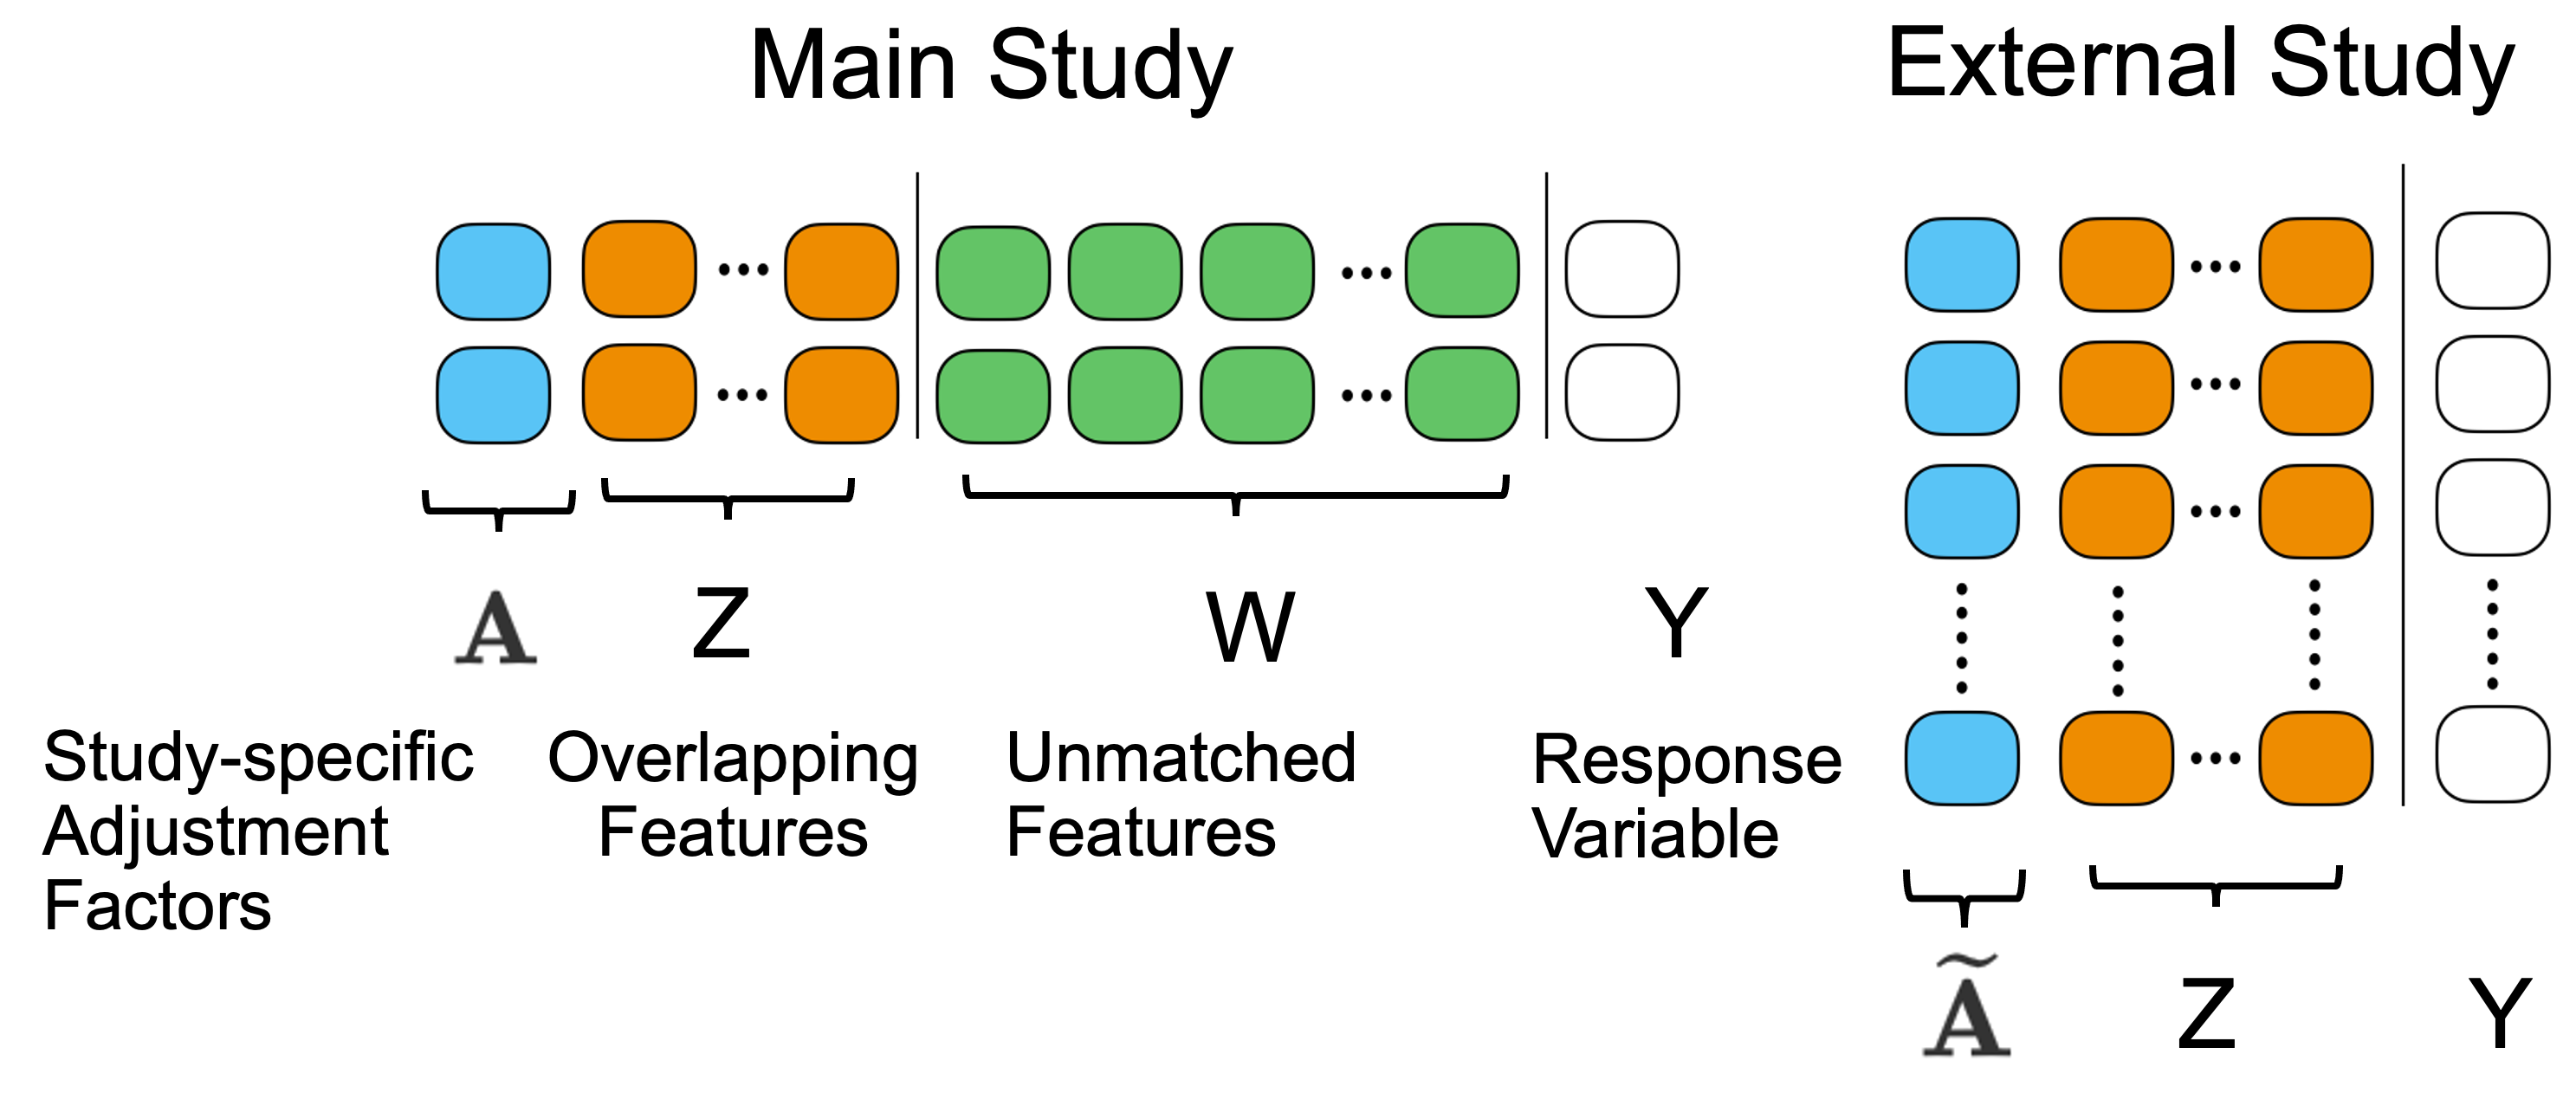



* **y** : Response Variable.

* **Z** : Overlapping Features.

* **W** : Unmatched Features.

* **study_info** : Parameter estimation from External study regarding overlapping features. "study_info" comes as list, including the information of estimated coefficient, estimated variance (variance-covariance matrix), external study sample size.

* **family** : Currently focus on linear ("gaussian") and logistic ("binomial").

* **A** : Study-specific Adjustment Factors.

* **penalty_type** : Select from c("lasso","adaptivelasso","ridge")

* **use_sparseC** : Whether to use approximate version of weighting matrix C. Default is FALSE.

* **inference** : Conduct post-selection inference for adaptive lasso penalty only. Default is FALSE.

## **Function Help Page**


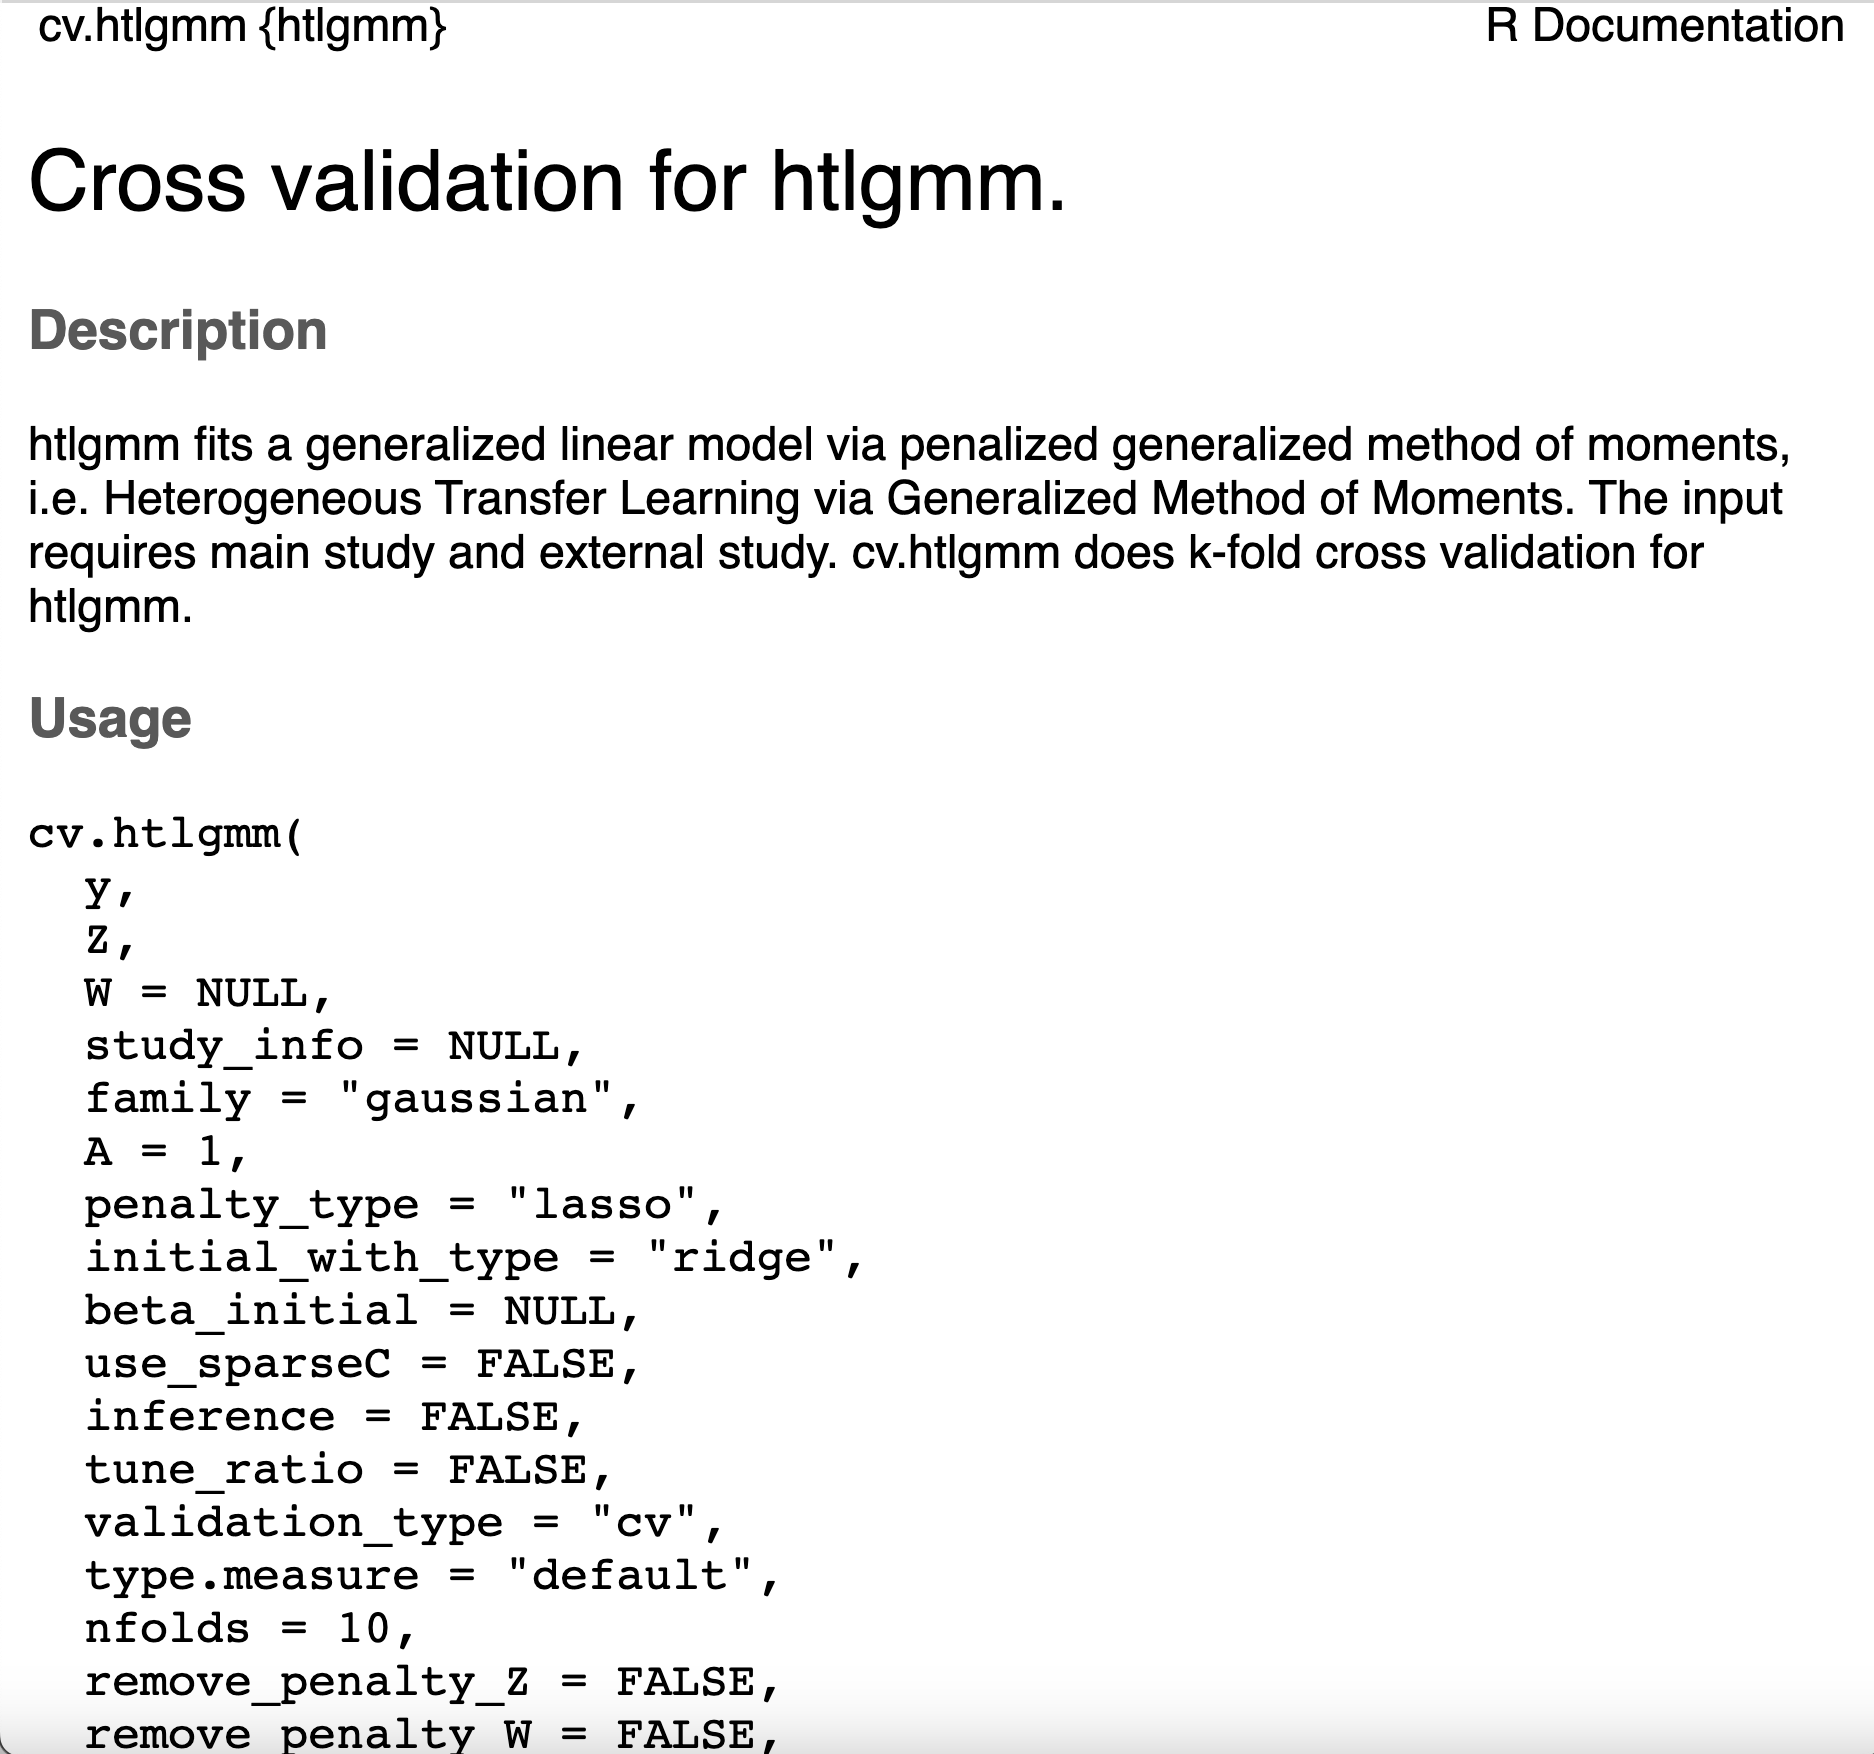

## Implementation of `cv.htlgmm` on example

Following the main input list of `cv.htlgmm`, we use the input of **y**, **Z** for overlapping features, **W** for unmatched features, **study_info** for external study information, **family** which is default for gaussian, **use_sparseC** for limited main study size and faster computation.


In [14]:
%%R
res_htlgmm<-cv.htlgmm(y=y,
                      Z=Z,
                      W=W,
                      study_info = study_info,
                      family = "gaussian",
                      penalty_type = "lasso",
                      use_sparseC = TRUE)

res_htlgmm_ada<-cv.htlgmm(y=y,
                          Z=Z,
                          W=W,
                          study_info = study_info,
                          family = "gaussian",
                          penalty_type = "adaptivelasso",
                          use_sparseC = TRUE,
                          inference = TRUE)

## Output list of `cv.htlgmm`

* **beta** : Target coefficient estimation. The coefficients go with the order of (Z,W,A).

* **lambda_list**: The lambda list for validation.

* **cv_mse**: The mean square error(mse) when family = "gaussian", and validation_type = "cv".

* **cv_dev**: The deviance(dev) when family = "binomial", and validation_type = "cv". For each lambda, cv_dev is the average deviance across all folds.

* **cv_auc**: The area under ROC curve(auc) when family = "binomial", and validation_type = "cv". An alternative choice of cv_dev.

* **lambda_min**: The selected best lambda.

* **selected_vars**: For post-selection inference, they are the corrected position passing significant level 0.05 after BH adjustment (Benjamini & Hochberg).

    * **position**: the position of nonzero predictors.

    * **coef**: the coefficient of nonzero predictors.

    * **pval**: the p values of nonzero predictors.

    * **variance**: the variance of nonzero predictors.
    
## Go over the output list one by one.

* **beta** : Target coefficient estimation. The coefficients go with the order of (Z,W,A).


In [15]:
%%R
est_coef_htlgmm<-res_htlgmm$beta
names(est_coef_htlgmm)<-c(paste0('Z',1:pZ),paste0('W',1:pW))
est_coef_htlgmm

         Z1          Z2          Z3          Z4          Z5          Z6 
 0.49106050  0.45577465  0.55109079 -0.02160957  0.00000000 -0.03695715 
         Z7          Z8          Z9         Z10         Z11         Z12 
 0.00000000  0.01561406  0.00000000 -0.02888777  0.00000000  0.00000000 
        Z13         Z14         Z15         Z16         Z17         Z18 
 0.04865234  0.00000000 -0.04013920  0.01013418  0.00000000  0.00000000 
        Z19         Z20          W1          W2          W3 
 0.00000000  0.00000000  0.41910427  0.50853201 -0.05400806 



* **selected_vars**: For post-selection inference, they are the corrected position passing significant level 0.05 after BH adjustment (Benjamini & Hochberg).

    * **position**: the position of nonzero predictors.

    * **coef**: the coefficient of nonzero predictors.

    * **pval**: the p values of nonzero predictors.

    * **variance**: the variance of nonzero predictors.

Check the true positions of predictosr with nonzero effects.

In [16]:
%%R
print("The predictos whose effects on outcome are nonzero.")
print(c(paste0('Z',1:pZ),paste0('W',1:pW))[coef!=0])

[1] "The predictos whose effects on outcome are nonzero."
[1] "Z1" "Z2" "Z3" "W1" "W2"


In [17]:
%%R
print('HTLGMM selected_vars')
print(res_htlgmm_ada$selected_vars)

[1] "HTLGMM selected_vars"
$position
 [1]  1  2  3  4  6 10 13 15 16 21 22 23

$coef
 [1]  0.50406321  0.46852761  0.56343173 -0.02396043 -0.03266721 -0.02928292
 [7]  0.05490071 -0.04280402  0.01275545  0.43956825  0.52417797 -0.06379813

$pval
          Z1           Z2           Z3           Z4           Z6          Z10 
3.434244e-64 2.934463e-54 1.378309e-81 4.594174e-01 2.921867e-01 3.274114e-01 
         Z13          Z15          Z16           W1           W2           W3 
6.803797e-02 1.658497e-01 7.028673e-01 8.715034e-21 1.010691e-29 1.367534e-01 

$variance
       Z1        Z2        Z3        Z4        Z6       Z10       Z13       Z15 
0.3551721 0.3649765 0.3469292 0.4195782 0.3847242 0.3576190 0.3620818 0.3816925 
      Z16        W1        W2        W3 
0.4472704 0.8839618 0.8572391 0.7353187 




* **lambda_list**: The lambda list for validation.

* **cv_mse**: The mean square error(mse) when family = "gaussian", and validation_type = "cv".

* **cv_dev**: The deviance(dev) when family = "binomial", and validation_type = "cv". For each lambda, cv_dev is the average deviance across all folds.

* **cv_auc**: The area under ROC curve(auc) when family = "binomial", and validation_type = "cv". An alternative choice of cv_dev.

In [18]:
%%R
head(lambda_mse_df<-data.frame(lambda=res_htlgmm$lambda_list,
                  cv_mse=res_htlgmm$cv_mse))

     lambda   cv_mse
1 1.5829574 2.261889
2 1.4423318 2.219077
3 1.3141991 2.164644
4 1.1974492 2.116859
5 1.0910711 2.062130
6 0.9941434 1.994146


* **lambda_min**: The selected best lambda based on cross validation (minimum mse, minimum deviance, maximum auc).


Check the estimation error of coefficients for cv.glmnet and cv.htlgmm.

In [19]:
%%R
lambda_min<-res_htlgmm$lambda_min
print(lambda_min)

[1] 0.04204474


In [20]:
%%R
est_coef_htlgmm<-res_htlgmm$beta
ee_htlgmm<-sum((coef-est_coef_htlgmm)^2)
ee_htlgmm<-round(ee_htlgmm,4)

ee_lasso<-sum((coef-est_coef_glmnet)^2)
ee_lasso<-round(ee_lasso,4)
print(paste0("Estimation Error: ","lasso(",ee_lasso,"); htlgmm(",ee_htlgmm,")"))

[1] "Estimation Error: lasso(0.0414); htlgmm(0.0212)"


The logistic regression based simulation

$$
\text{expit} = \frac{\exp(x)}{1+\exp(x)}
$$

Use the same coefficient but **binomial** distribution for **y**.


In [21]:
%%R
y_joint<-rbinom(n=n_joint,size=1,prob=locfit::expit(cbind(Z_joint,W_joint)%*%coef))
y<-y_joint[main_index]
yE<-y_joint[-main_index]


Summarize external study, we use GLM for binary case.

In [22]:
%%R
resglm<-glm(y~.,data = data.frame(y=yE,ZE),family = "binomial")
study_external = list(
                Coeff=resglm$coefficients[-1],
                Covariance=vcov(resglm)[-1,-1],
                Sample_size=nE)
study_info<-list()
study_info[[1]] <- study_external
study_info

[[1]]
[[1]]$Coeff
          Z1           Z2           Z3           Z4           Z5           Z6 
 0.498020091  0.504179534  0.465572780  0.021248703 -0.024573226  0.046705358 
          Z7           Z8           Z9          Z10          Z11          Z12 
-0.008714262  0.015014867 -0.006216922 -0.029221479  0.016800403 -0.028612410 
         Z13          Z14          Z15          Z16          Z17          Z18 
-0.026758672 -0.003445746  0.036301159  0.033057309 -0.019028153  0.081181343 
         Z19          Z20 
-0.054513556 -0.008400133 

[[1]]$Covariance
               Z1            Z2            Z3            Z4            Z5
Z1   2.607927e-03  2.767996e-04  1.461200e-04  6.855771e-05 -1.533499e-05
Z2   2.767996e-04  2.594810e-03  2.058085e-04  1.158041e-04 -1.297203e-04
Z3   1.461200e-04  2.058085e-04  2.563294e-03 -4.681452e-05 -2.965120e-05
Z4   6.855771e-05  1.158041e-04 -4.681452e-05  2.375812e-03 -5.355010e-05
Z5  -1.533499e-05 -1.297203e-04 -2.965120e-05 -5.355010e-05  2.370

Cross validation with lasso using `cv.glmnet`.

In [23]:
%%R
library(glmnet)
res_glmnet<-cv.glmnet(x=cbind(Z,W),y=y,family="binomial")

Train with `cv.htlgmm`, the family is `binomial`.


In [24]:
%%R
res_htlgmm<-cv.htlgmm(y=y,
                      Z=Z,
                      W=W,
                      family="binomial",
                      study_info = study_info,
                      use_sparseC = TRUE)

Check the estimation error between estimated coefficients and true coefficients.

In [25]:
%%R
est_coef_htlgmm<-res_htlgmm$beta[-length(res_htlgmm$beta)]
ee_htlgmm<-sum((coef-est_coef_htlgmm)^2)
ee_htlgmm<-round(ee_htlgmm,4)

est_coef_lasso<-coef.glmnet(res_glmnet,s="lambda.min")[-1]
ee_lasso<-sum((coef-est_coef_lasso)^2)
ee_lasso<-round(ee_lasso,4)

print(paste0("Estimation Error: ","lasso(",ee_lasso,"); htlgmm(",ee_htlgmm,")"))

[1] "Estimation Error: lasso(0.1668); htlgmm(0.052)"



# Real Application Example

## **The real application is 10-year risk of “incident” Stroke**


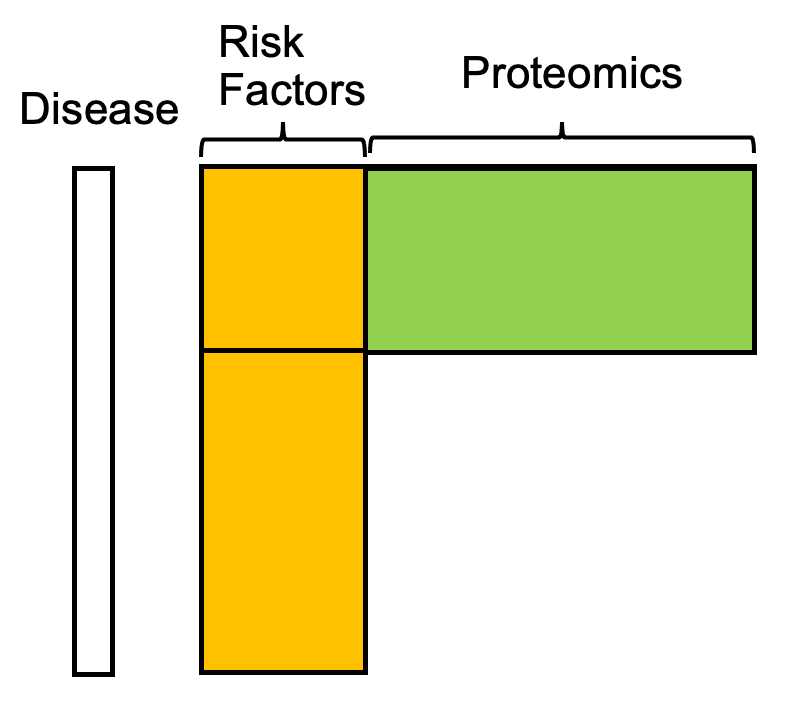

The proteomics data are downloaded from https://www.ukbiobank.ac.uk/enable-your-research/about-our-data/past-data-releases

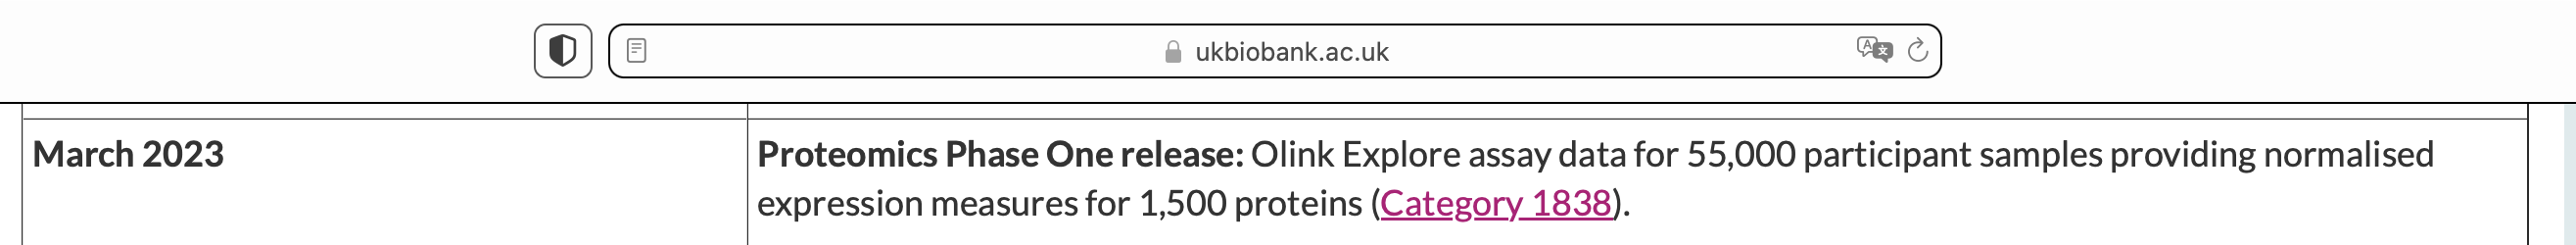


The risk factors are downloaded from https://biobank.ndph.ox.ac.uk/showcase/browse.cgi


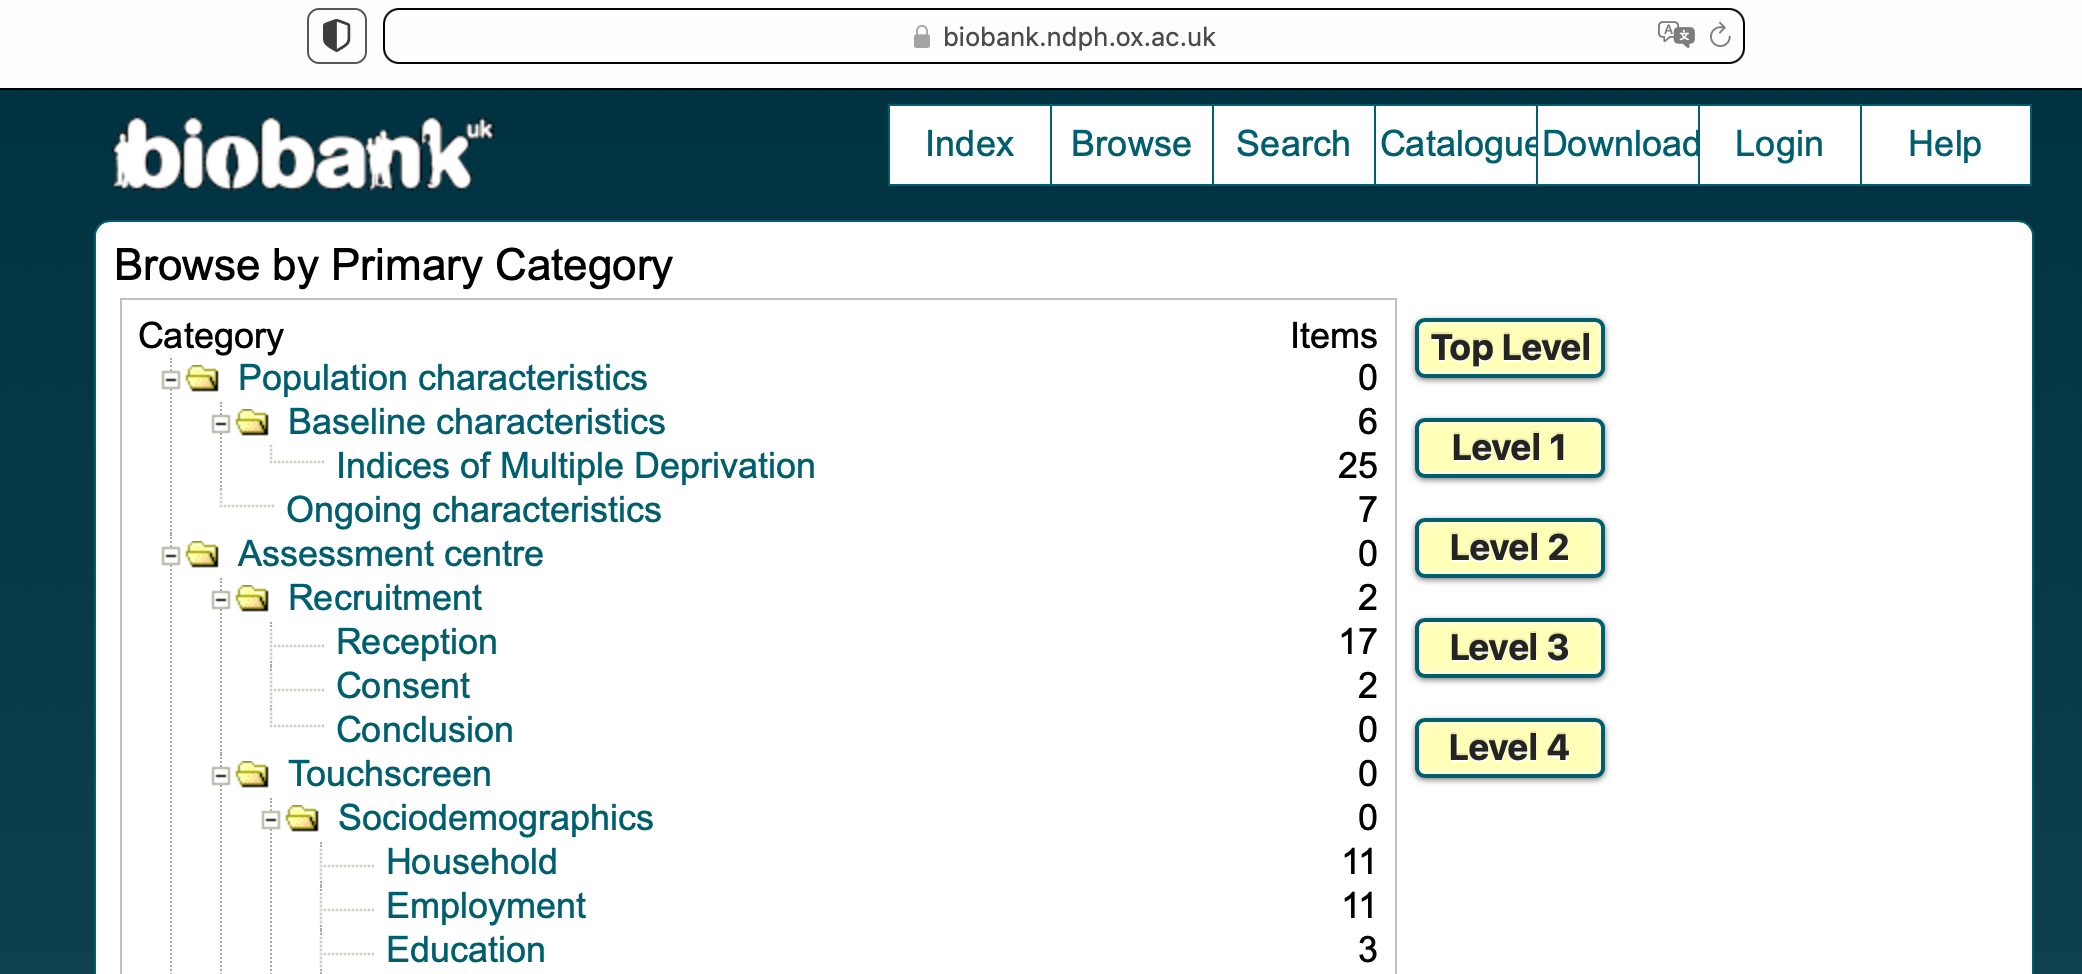


The most recent analysis comes from May 2023:

Gadd, Danni A., et al. "Blood protein levels predict leading incident diseases and mortality in UK Biobank." medRxiv (2023): 2023-05.


Load the required package including `htlgmm`.


Load the required package including **`htlgmm`**.


In [26]:
%%R

library(caret)
library(glmnet)
library(htlgmm)
library(pROC)




Attaching package: ‘pROC’



    cov, smooth, var





## Simulated UKB data including disease status, risk factor and proteomics

The risk factors names are listed from the Stroke related ones. Record the summarized mean and standard deviance for each risk factor, including whether the predictors are binary or continuous.

In [27]:
%%R
risk_factor_names<-c("sex","age","dbp","sbp","T2D","height","BMI","cholesterol","HDL","LDL","crp","pulse_rate","trig","hyperlipid","SmokingStatus","AlcoholFreq","PackYrs","Basal_metabolic_rate","Aspirin","statin","father.Stroke","mother.Stroke","physical","edu","social","diet")

mean_risk_factor<-c(0.4544,56.7359,82.1773,136.0661,0.0479,168.6782,27.3743,221.0858,56.2353,138.1562,2.5619,69.4559,154.7082,0.8422,0.5607,2.8560,10.5340,6626.7823,0.1363,0.1737,0.1359,0.1314,2669.5590,0.3277,0.7016,0.7360)

sd_risk_factor<-c(0.4979,8.0211,9.9597,18.1335,0.2135,9.2446,4.7546,43.6913,14.0612,33.2142,4.2946,11.2386,89.9247,0.3645,0.6716,1.4821,15.4259,1358.2518,0.3431,0.3788,0.3427,0.3379,2453.7016,0.4694,0.4576,0.5951)

names(mean_risk_factor)<-risk_factor_names
print(mean_risk_factor)

                 sex                  age                  dbp 
              0.4544              56.7359              82.1773 
                 sbp                  T2D               height 
            136.0661               0.0479             168.6782 
                 BMI          cholesterol                  HDL 
             27.3743             221.0858              56.2353 
                 LDL                  crp           pulse_rate 
            138.1562               2.5619              69.4559 
                trig           hyperlipid        SmokingStatus 
            154.7082               0.8422               0.5607 
         AlcoholFreq              PackYrs Basal_metabolic_rate 
              2.8560              10.5340            6626.7823 
             Aspirin               statin        father.Stroke 
              0.1363               0.1737               0.1359 
       mother.Stroke             physical                  edu 
              0.1314            2669.559

We assume all binary risk factors follow binomial distribution and continuous risk factors follow normal distribution. We follow the same disease prevalence of Stroke from UKB. The main study is assumed to be 10K, and the external study is 9 times more, where the ratio is similar to actual case.

Although there are in total 15K proteins in proteomics data, we assume there are 200 proteins in simulation.

In [28]:
%%R
binary_predictors<-c("sex","T2D","hyperlipid","SmokingStatus","Aspirin","statin","father.Stroke","mother.Stroke","edu","social","diet")

n_main<-10000
n_external<-90000
n_joint<-n_main+n_external
p_protein<-200
risk_factor<-list()
for( i in which(risk_factor_names%in%binary_predictors)){
    risk_factor[[i]]<-rbinom(n = n_joint,size = 1,prob = mean_risk_factor[i])
}
for( i in which(!risk_factor_names%in%binary_predictors)){
    risk_factor[[i]]<-rnorm(n = n_joint,mean = mean_risk_factor[i],sd = sd_risk_factor[i])
}
risk_factor_matrix<-Reduce("cbind",risk_factor)

Check the data structure of the risk factor matrix, which is similar to the actual data structure.

In [29]:
%%R
colnames(risk_factor_matrix)<-risk_factor_names
round(head(risk_factor_matrix,2),2)

     sex   age   dbp    sbp T2D height   BMI cholesterol   HDL    LDL  crp
[1,]   1 52.63 80.27 165.16   0 181.90 22.81      253.29 60.89 129.16 0.46
[2,]   0 57.37 84.08 129.72   0 161.01 30.94      210.45 61.29 102.46 0.58
     pulse_rate  trig hyperlipid SmokingStatus AlcoholFreq PackYrs
[1,]      69.67 84.93          1             0        2.37   12.89
[2,]      57.32 -4.11          1             0        1.65   21.44
     Basal_metabolic_rate Aspirin statin father.Stroke mother.Stroke physical
[1,]              6703.98       1      0             0             0  3363.96
[2,]              6839.11       0      0             0             0  5489.43
     edu social diet
[1,]   1      1    1
[2,]   1      1    1



The proteins are assumed to follow N(0,1).

In [30]:
%%R
proteomics_matrix<-matrix(rnorm(n_joint*p_protein),nrow = n_joint,ncol = p_protein)
eg_proteomics<-proteomics_matrix[1:6,1:5]
colnames(eg_proteomics)<-c("aarsd1","abhd14b","abl1","acaa1","ace2")
eg_proteomics

          aarsd1    abhd14b        abl1      acaa1       ace2
[1,] -0.52351275 -0.1650609 -0.11427517  1.1924578  0.6847854
[2,] -0.56816005 -2.3044206 -0.69394226 -2.0769323 -0.1110615
[3,]  0.73540867  1.0189194 -1.13674962  1.1733944  0.1761003
[4,] -0.06463737 -0.1101567  0.02631153  1.3979223  0.7898039
[5,]  1.71409754  2.2031612  1.64312064  0.0366995  0.6623715
[6,]  0.29790269  0.6039755  1.53544443  0.5039537 -0.3919164


We assume the disease status follows binomial distribution, and the disease prevalence uses the similar actual case ratio (roughly 1%).

In [31]:
%%R
coef_risk_factor<-rep(0,length(risk_factor_names))
coef_proteomics<-rep(0,p_protein)
set.seed(2023)
coef_risk_factor[c(1,4,9,16,25)]<- 0.3
coef_proteomics[c(1,4,9,16,25)]<- -0.2

mean_case<-0.0108
Y<-rbinom(n_joint,size = 1,prob =locfit::expit(
    log(mean_case/(1-mean_case))+c(scale(risk_factor_matrix)%*%coef_risk_factor)+c(proteomics_matrix%*%coef_proteomics)))
print(paste0("simulated disease prevalence:",sum(Y)/n_joint))

[1] "simulated disease prevalence:0.01494"



Separate the simulated data into main study and external study.


In [32]:
%%R
main_study<-data.frame(Y = Y[1:n_main],risk_factor_matrix[1:n_main,],proteomics_matrix[1:n_main,])

external_study<-data.frame(Y = Y[-c(1:n_main)],risk_factor_matrix[-c(1:n_main),])

Scale the predictors from main study and external study.

In [33]:
%%R
main_study[,-1]=scale(main_study[,-1])
external_study[,-1]=scale(external_study[,-1])


Extract summary statistics from external study.

In [34]:
%%R
family = "binomial"
study_info=list()
external_glm=glm(Y~.,data = external_study,family = family)
study_external = list(
                Coeff=external_glm$coefficients[-1],
                Covariance=vcov(external_glm)[-1,-1],
                Sample_size=nrow(external_study))
study_info[[1]] = study_external
study_info

[[1]]
[[1]]$Coeff
                 sex                  age                  dbp 
         0.286155095         -0.051500069         -0.030623683 
                 sbp                  T2D               height 
         0.284984786          0.001367947         -0.005489246 
                 BMI          cholesterol                  HDL 
        -0.061091843          0.022684197          0.255824789 
                 LDL                  crp           pulse_rate 
         0.028573284         -0.005097091         -0.028010377 
                trig           hyperlipid        SmokingStatus 
         0.010035949          0.010400981         -0.008163006 
         AlcoholFreq              PackYrs Basal_metabolic_rate 
         0.294411944         -0.008288375         -0.003435073 
             Aspirin               statin        father.Stroke 
        -0.015522548         -0.012562735          0.005251111 
       mother.Stroke             physical                  edu 
        -0.020551465  


Split main study into train and test with the proportion (70% and 30%).

In [35]:
%%R
library(caret)
set.seed(2023)
test_index=createDataPartition(main_study$Y,p = 0.3)$Resample1


y and X are training set for main study

In [36]:
%%R
y = main_study$Y[-test_index]
X = as.matrix(main_study[-test_index,-1])
X=scale(X)
y_test = main_study$Y[test_index]
X_test = as.matrix(main_study[test_index,-1])
X_test = scale(X_test)
p_risk = ncol(external_study)-1

Perform `cv.glmnet` only for main study's training set and check the performance on main study's test set. The criterion is AUC.

In [37]:
%%R
start_t=Sys.time()
main_lasso=cv.glmnet(x=X, y=y, family=family)
end_t=Sys.time()
sprintf('cv.glmnet time: %.2f %s', end_t-start_t, units(end_t-start_t))

[1] "cv.glmnet time: 23.78 secs"


In [38]:
%%R
pred_main_lasso=predict(main_lasso,newx=X_test)
library(pROC)
auc_main_lasso=auc(y_test,c(locfit::expit(pred_main_lasso)))


Perform `cv.htlgmm` only for main study's training set and check the performance on main study's test set.

In [39]:
%%R
start_t=Sys.time()
main_external_htlgmm=cv.htlgmm(y = y,
                               Z = X[,c(1:p_risk)],
                               W = X[,-c(1:p_risk)],
                               study_info = study_info,
                               family = "binomial",
                               A = 1,nfolds = 10,
                               use_sparseC = T)
end_t=Sys.time()
sprintf('cv.htlgmm time: %.2f %s', end_t-start_t, units(end_t-start_t))

[1] "cv.htlgmm time: 39.82 secs"


Check the AUC comparison between `cv.glmnet` and `cv.htlgmm`.

In [40]:
%%R
pred_main_external_htlgmm=X_test%*%main_external_htlgmm$beta[1:ncol(X_test)]
auc_main_external_htlgmm=auc(y_test,c(locfit::expit(pred_main_external_htlgmm)))
print(paste0("AUC on test data: lasso(",round(auc_main_lasso,4) ,"); htlgmm(",round(auc_main_external_htlgmm,4),")"))

[1] "AUC on test data: lasso(0.5); htlgmm(0.5604)"


More details of the output

In [41]:
%%R
print(list("lambda_list"=main_external_htlgmm$lambda_list,
           "cv_dev"=main_external_htlgmm$cv_dev,
           "cv_auc"=main_external_htlgmm$cv_auc,
           "lambda_min"=main_external_htlgmm$lambda_min))

$lambda_list
 [1] 1.638687e-02 1.493111e-02 1.360467e-02 1.239607e-02 1.129484e-02
 [6] 1.029143e-02 9.377171e-03 8.544129e-03 7.785092e-03 7.093486e-03
[11] 6.463321e-03 5.889137e-03 5.365962e-03 4.889265e-03 4.454916e-03
[16] 4.059154e-03 3.698550e-03 3.369981e-03 3.070601e-03 2.797817e-03
[21] 2.549267e-03 2.322797e-03 2.116446e-03 1.928427e-03 1.757111e-03
[26] 1.601014e-03 1.458784e-03 1.329190e-03 1.211108e-03 1.103517e-03
[31] 1.005483e-03 9.161590e-04 8.347700e-04 7.606113e-04 6.930407e-04
[36] 6.314729e-04 5.753745e-04 5.242599e-04 4.776861e-04 4.352497e-04
[41] 3.965834e-04 3.613520e-04 3.292505e-04 3.000008e-04 2.733495e-04
[46] 2.490659e-04 2.269396e-04 2.067789e-04 1.884092e-04 1.716715e-04
[51] 1.564206e-04 1.425247e-04 1.298632e-04 1.183265e-04 1.078147e-04
[56] 9.823673e-05 8.950965e-05 8.155786e-05 7.431248e-05 6.771076e-05
[61] 6.169553e-05 5.621467e-05 5.122071e-05 4.667040e-05 4.252433e-05
[66] 3.874659e-05 3.530445e-05 3.216810e-05 2.931037e-05

$cv_dev
 [1] 121.38


Plot to show the change of cross validation deviance against log lambda (tuning parameter for lasso penalty).


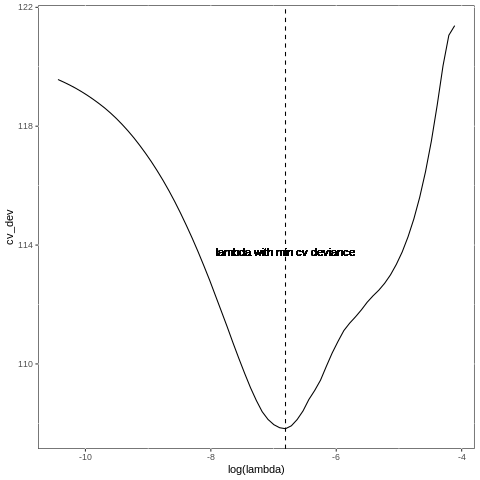

In [42]:
%%R
df = data.frame(lambda = main_external_htlgmm$lambda_list,
                cv_dev=main_external_htlgmm$cv_dev,
                cv_auc=main_external_htlgmm$cv_auc)
library(ggplot2)
ggplot(df)+
  geom_line(aes(x=log(lambda),y=cv_dev))+
  geom_vline(xintercept = log(main_external_htlgmm$lambda_min),
             linetype=2)+
  theme(panel.background=element_rect(fill='transparent', color='black'))+
  geom_text(aes(x=log(main_external_htlgmm$lambda_min),y=median(df$cv_dev),label='lambda with min cv deviance'))


# Feedback

https://github.com/RuzhangZhao/htlgmm/issues

Please submit any feedback and bugs on github issue page.
